In [1]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
import qtm.base_qtm, qtm.constant, qtm.qtm_nqubit, qtm.qtm_1qubit

In [2]:
num_qubits = 3
phis = np.random.uniform(low = 0, high = 2*np.pi, size = num_qubits*10)
thetas = np.random.uniform(low = 0, high = 2*np.pi, size = 2**(num_qubits + 1) - 2)

In [3]:
def create_rx_nqubit(qc: qiskit.QuantumCircuit, thetas):
    for i in range(0, qc.num_qubits):
        qc.rx(thetas[i], i)
    return qc
def create_rz_nqubit(qc: qiskit.QuantumCircuit, thetas):
    for i in range(0, qc.num_qubits):
        qc.rz(thetas[i], i)
    return qc
def create_cry_nqubit(qc: qiskit.QuantumCircuit, thetas):
    """Create control R_Y state

    Args:
        - qc (QuantumCircuit): Init circuit
    
    Returns:
        - QuantumCircuit: the added circuit
    """
    for i in range(0, qc.num_qubits - 1, 2): 
        qc.cx(i, i + 1)
    for i in range(1, qc.num_qubits - 1, 2): 
        qc.cx(i, i + 1)
    qc.cx(qc.num_qubits - 1, 0)        
    return qc
def create_cry_nqubit_inverse(qc: qiskit.QuantumCircuit, thetas):
    """Create control R_Y state

    Args:
        - qc (QuantumCircuit): Init circuit
    
    Returns:
        - QuantumCircuit: the added circuit
    """
    for i in range(0, qc.num_qubits - 1, 2): 
        qc.cx(i + 1, i)
    for i in range(1, qc.num_qubits - 1, 2): 
        qc.cx(i + 1, i)
    qc.cx(0, qc.num_qubits - 1)        
    return qc
def create_arbitrary_nqubit(qc: qiskit.QuantumCircuit, thetas, n_layers):
    n = qc.num_qubits
    for i in range(0, n_layers):
        phis = thetas[i:(i + 1)*n*5]
        qc = create_rx_nqubit(qc, phis[:n])
        qc = create_cry_nqubit_inverse(qc, phis[n:n*2])
        qc = create_rz_nqubit(qc, phis[n*2:n*3])
        qc = create_cry_nqubit(qc, phis[n*3:n*4])
        qc = create_rz_nqubit(qc, phis[n*4:n*5])
    return qc
def u_arbitrary_nqubit(qc, thetas):
    qc.rx(thetas[0], 0)
    qc.ry(thetas[1], 0)
    qc.rx(thetas[2], 1)
    qc.ry(thetas[3], 1)
    qc.rx(thetas[4], 2)
    qc.ry(thetas[5], 2)
    qc.rxx(thetas[6], 1, 2)
    qc.rzx(thetas[7], 1, 2)
    qc.rxx(thetas[8], 0, 1)
    qc.rzx(thetas[9], 0, 1)
    qc.rxx(thetas[10], 1, 2)
    qc.rzx(thetas[11], 1, 2)
    qc.rxx(thetas[12], 0, 1)
    qc.rzx(thetas[13], 0, 1)
    return qc


In [4]:
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
qc = create_arbitrary_nqubit(qc, phis, n_layers = 2)


# qc = u_arbitrary_nqubit(qc, thetas)
# for i in range(0, num_qubits):
#     qc.measure(i, i)
# qobj = qiskit.assemble(qc, shots = qtm.constant.shots)  
# counts = (qiskit.Aer.get_backend('qasm_simulator')).run(qobj).result().get_counts()
# print(counts.get("0" * qc.num_qubits, 0) / qtm.constant.shots)

# Reduce loss value in 100 steps
thetas, loss_values = qtm.base_qtm.fit(
    qc, num_steps = 200, thetas = thetas, 
    create_circuit_func = u_arbitrary_nqubit, 
    grad_func = qtm.base_qtm.grad_l,
    loss_func = qtm.base_qtm.loss_basis,
    verbose = 1
)

Step: 100%|██████████| 200/200 [05:00<00:00,  1.50s/it]


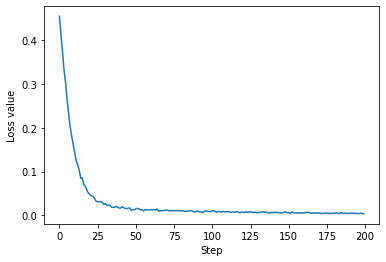

In [5]:
plt.show()
plt.plot(loss_values)
plt.xlabel("Step")
plt.ylabel("Loss value")
plt.show()

In [17]:
def get_u_arbitrary_nqubit_hat(thetas, num_qubits: int = 1):
    """Get psi_hat of u_nlayer_nqubit

    Args:
        - thetas (Numpy array): Parameters
        - num_qubits (int, optional): Number of qubits. Defaults to 1.

    Returns:
        - Statevector: State vectpr of u_nqubit_dagger
    """
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc = u_arbitrary_nqubit(qc, thetas).inverse()
    return qiskit.quantum_info.Statevector.from_instruction(qc)
# Get statevector from circuit
psi = qiskit.quantum_info.Statevector.from_instruction(qc)
rho_psi = qiskit.quantum_info.DensityMatrix(psi)
# psi_hat = qiskit.quantum_info.Statevector()
# rho_psi_hat = qiskit.quantum_info.DensityMatrix(psi_hat)
# Calculate the metrics
# print(get_u_arbitrary_nqubit_hat(thetas, 3))

# trace, fidelity = qtm.base_qtm.get_metrics(psi, psi_hat)
# print("Trace: ", trace)
# print("Fidelity: ", fidelity)